In [1]:
#@title Step 1: Importing the necessary libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import time
import itertools
import os

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#@title Step 2: Load preprocessed (sequenced) data; Splitting data into training and testing datasets

import pickle

# Load sequences and vehicle IDs from a file
#with open('/content/drive/MyDrive/2024-05- 7088CEM (ANN Module)/Assignments/handover_prediction/Data/sequences_vehicle_ids.pkl', 'rb') as f:
with open('Data/sequences_vehicle_ids.pkl', 'rb') as f:
    sequences, vehicle_ids = pickle.load(f)

# Split data into training and testing
train_size = int(0.8 * len(sequences))
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]
train_vehicle_ids = vehicle_ids[:train_size]
test_vehicle_ids = vehicle_ids[train_size:]

class VehicleDataset(Dataset):
    def __init__(self, sequences, flatten=False):
        self.sequences = sequences
        self.flatten = flatten # new

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq, target = self.sequences[idx]
        seq_tensor = torch.Tensor(seq)
        if self.flatten:
            seq_tensor = seq_tensor.view(-1)  # Flatten the sequence
        return seq_tensor, torch.Tensor(target)

# Create DataLoader objects for the full dataset
train_dataset_all = VehicleDataset(train_sequences, flatten=False)
test_dataset_all = VehicleDataset(test_sequences, flatten=False)

train_loader_all = DataLoader(train_dataset_all, batch_size=32, shuffle=True)
test_loader_all = DataLoader(test_dataset_all, batch_size=32, shuffle=False)

###########Use only 20% of data for hyperparameter tuning######################

# Split train dataset for hyperparameter tuning
tune_size = int(0.2 * len(train_sequences))  # Use 20% of the training data for tuning
tune_sequences = train_sequences[:tune_size]
tune_vehicle_ids = train_vehicle_ids[:tune_size]

tune_dataset = VehicleDataset(tune_sequences, flatten=False)
tune_test_size = int(0.2 * len(test_sequences))  # Use 20% of the testing data for tuning
tune_test_sequences = test_sequences[:tune_test_size]

tune_test_dataset = VehicleDataset(tune_test_sequences, flatten=False)

# Create DataLoader objects for tuning set
train_loader = DataLoader(tune_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(tune_test_dataset, batch_size=32, shuffle=False)

In [3]:
#@title Step 3: Defining the methods (architecture of NN layers and activation functions)

#### Step 3a: Define the Long Short-Term Memory (LSTM) model

import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

#### Step 3b: Define the Gated Recurrent Unit (GRU) model

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


#### Step 3c: Define the generic Recurrent Neural Network (RNN) model

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


#### Step 3d: Define 1-d CNN (Conv1D) model

class Conv1DModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Conv1DModel, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()

        # Input layer
        self.conv_layers.append(nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1))
        self.pool_layers.append(nn.MaxPool1d(kernel_size=2, stride=1))  # Reduced stride

        # Hidden layers
        for _ in range(1, num_layers):
            self.conv_layers.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1))
            self.pool_layers.append(nn.MaxPool1d(kernel_size=2, stride=1))  # Reduced stride

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)  # Swap dimensions to fit Conv1d input format
        for conv, pool in zip(self.conv_layers, self.pool_layers):
            x = F.relu(conv(x))
            x = pool(x)
        x = x.mean(dim=2)  # Global average pooling
        x = self.fc(x)
        return x
    
#### Step 3e: Define a simple Multi-layer Perceptron (MLP) model

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MLPModel, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]

        for _ in range(1, num_layers):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])

        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x.view(x.size(0), -1))

In [4]:
#@title Step 4: Training method (generic for all baselines)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda', early_stopping_rounds=4, min_delta=0.01):
    model.to(device)
    epoch_times = []
    epoch_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_loss = total_loss / len(train_loader)
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)
        epoch_losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.8f}, Time: {epoch_time:.2f}s')

        # Early stopping mechanism
        if epoch >= early_stopping_rounds:
          recent_losses = epoch_losses[-early_stopping_rounds:]
          if all(abs(recent_losses[i] - recent_losses[i-1]) < min_delta * recent_losses[i-1] for i in range(1, early_stopping_rounds)):
              print(f"Early stopping at epoch {epoch+1}")
              break

    return epoch_times, epoch_losses

In [5]:
#@title Step 5: Model Evaluation

from sklearn.metrics import mean_absolute_error, r2_score

def evaluate_model(model, test_loader, device='cuda'):
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f'RMSE: {rmse:.8f}')
    print(f'MAE: {mae:.8f}')
    print(f'R2 Score: {r2:.8f}')

    return predictions, actuals, rmse, mae, r2

In [6]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")
print(torch.__version__)
print(torch.version.cuda)


True
1
Quadro RTX 4000
2.0.1+cu117
11.7


In [8]:
#@title Step 6: Define a method to run the training and evaluation of the model for different sets of hyperparameters

def run_experiment(params, input_size=4, output_size=2, model_type='LSTM'):
    hidden_size, num_layers, learning_rate, num_epochs = params
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if model_type == 'LSTM':
        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'Experiments/Tuning/hyperparam_tuning_LSTM.csv'
    elif model_type == 'GRU':
        model = GRUModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'Experiments/Tuning/hyperparam_tuning_GRU.csv'
    elif model_type == 'RNN':
        model = RNNModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'Experiments/Tuning/hyperparam_tuning_results_RNN.csv'
    elif model_type == 'Conv1D':
        model = Conv1DModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'Experiments/Tuning/hyperparam_tuning_Conv1D.csv'
    elif model_type == 'MLP':
        example_input, _ = next(iter(train_loader))
        flattened_input_size = example_input.view(example_input.size(0), -1).size(1)
        model = MLPModel(flattened_input_size, hidden_size, num_layers, output_size)
        save_path = 'Experiments/Tuning/hyperparam_tuning_MLP.csv'
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Initialize criterion and optimizer
    criterion = nn.MSELoss() # mean squared error (MSE) is the criterion for evaluating loss in each epoch
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Using Adam optimizer

    # Train the model and measure time 
       
    #%%%%%%% TRAIN %%%%%%
    # Use the provided train_model function
    epoch_times, epoch_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    #%%%%%%% TEST %%%%%%
    # Evaluate the model
    predictions, actuals, rmse, mae, r2 = evaluate_model(model, test_loader, device=device)

    # Calculate average epoch time
    avg_epoch_time = np.mean(epoch_times)

    result = {
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'avg_epoch_time': avg_epoch_time,
        'epoch_times': epoch_times,
        'epoch_losses': epoch_losses
    }

    results_df = pd.DataFrame([result])
    if save_path:
        if os.path.exists(save_path):
            results_df.to_csv(save_path, mode='a', header=False, index=False)
        else:
            results_df.to_csv(save_path, index=False)

    return result


In [9]:
#@title Step 7: Define hyperparameter sets

# Define the hyperparameter grid (5*4*8*1 = 160 total possibilities)
param_grid = {
    'hidden_size': [32, 50, 64, 100, 128],
    'num_layers': [2, 3, 4, 5],
    'learning_rate': [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001],
    'num_epochs': [30] 
}

# Create a list of hyperparameter combinations
param_combinations = list(itertools.product(
    param_grid['hidden_size'],
    param_grid['num_layers'],
    param_grid['learning_rate'],
    param_grid['num_epochs']
))

def run_specific_experiment(index, input_size=4, output_size=2, model_type='LSTM'): # allowed number for index: 0-159
    if index < 0 or index >= len(param_combinations):
        raise ValueError("Index out of range")
    
    params = param_combinations[index]

    print('Model type: ', model_type)
    print('Index of experiment / total number of experiments: ', str(index+1), ' / ',str(len(param_combinations)))
    print('Hyperparameters set (hidden_size, num_layers, learning_rate, num_epochs): ', params)

    result = run_experiment(params, input_size, output_size, model_type)
    print('---------\n---------\n')
    
    return result

In [10]:
#@title Step 8: Execute each method (flexible for continuing unfinished experiments)

# We have 160 sets of experiments due to the different values for hyperparameters in param_grid (defined in Step 7)
for i in range(160):
    result = run_specific_experiment(index=i, model_type='LSTM')
for i in range(160):
    result = run_specific_experiment(index=i, model_type='GRU')
for i in range(160):
    result = run_specific_experiment(index=i, model_type='RNN')
for i in range(160): 
    result = run_specific_experiment(index=i, model_type='Conv1D')
for i in range(160):
    result = run_specific_experiment(index=i, model_type='MLP')

Model type:  LSTM
Index of experiment / total number of experiments:  1  /  160
Hyperparameters set (hidden_size, num_layers, learning_rate, num_epochs):  (32, 2, 0.05, 30)
Epoch [1/30], Loss: 118608.91975583, Time: 19.92s
Epoch [2/30], Loss: 35861.88385889, Time: 22.87s
Epoch [3/30], Loss: 35867.79383670, Time: 22.31s
Epoch [4/30], Loss: 35864.52481526, Time: 22.10s
Epoch [5/30], Loss: 35867.58277580, Time: 22.57s
Early stopping at epoch 5
RMSE: 179.72998047
MAE: 128.85469055
R2 Score: -0.04208028
---------
---------

Model type:  LSTM
Index of experiment / total number of experiments:  2  /  160
Hyperparameters set (hidden_size, num_layers, learning_rate, num_epochs):  (32, 2, 0.01, 30)
Epoch [1/30], Loss: 379795.62953819, Time: 22.84s
Epoch [2/30], Loss: 35863.84670368, Time: 22.85s
Epoch [3/30], Loss: 35847.00258866, Time: 22.49s
Epoch [4/30], Loss: 35847.88442087, Time: 22.37s
Epoch [5/30], Loss: 35851.27890914, Time: 22.85s
Early stopping at epoch 5
RMSE: 180.76832581
MAE: 128.49

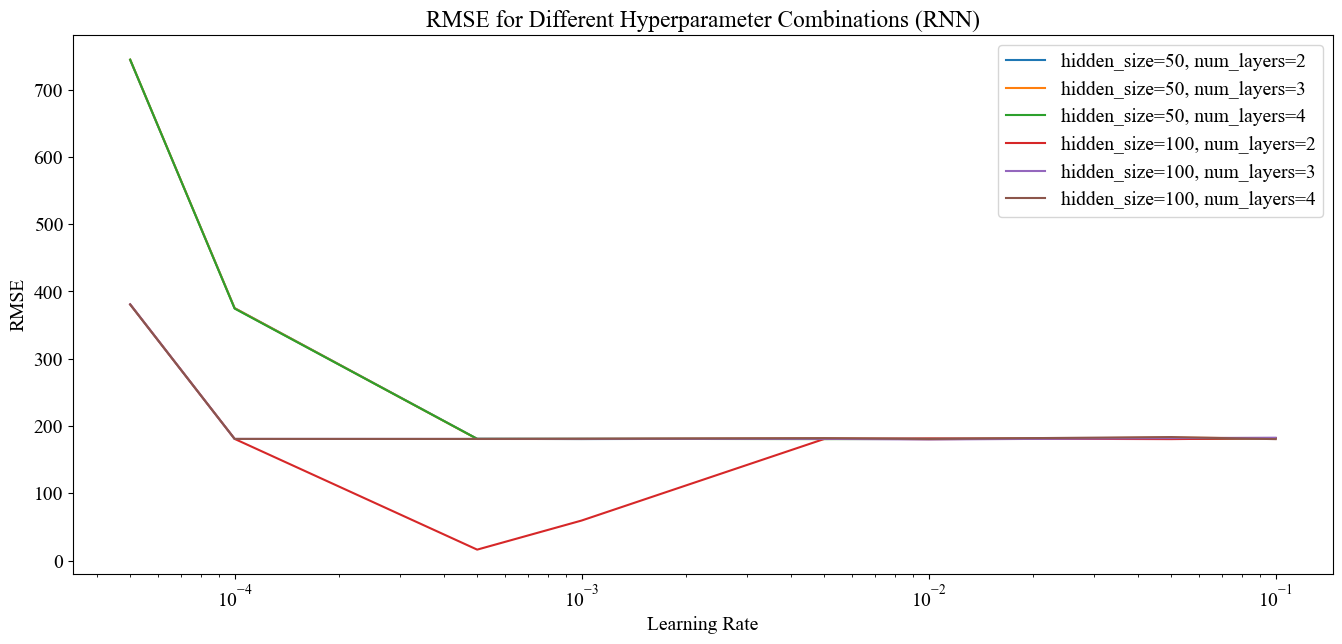

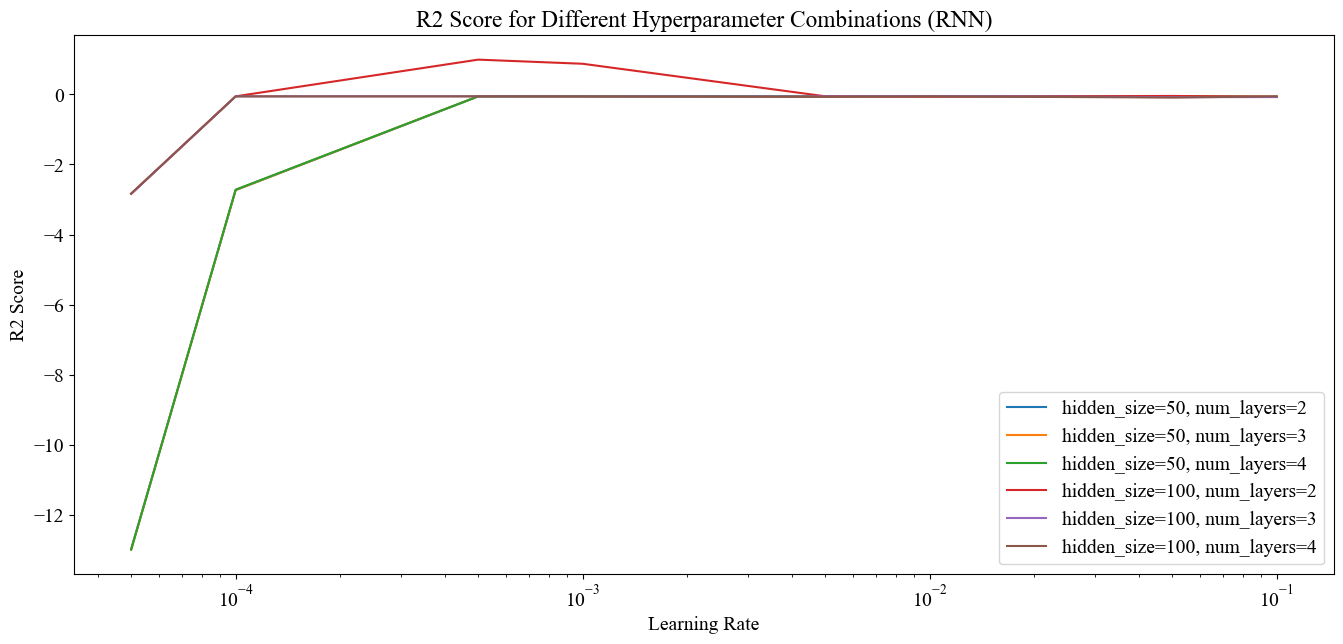

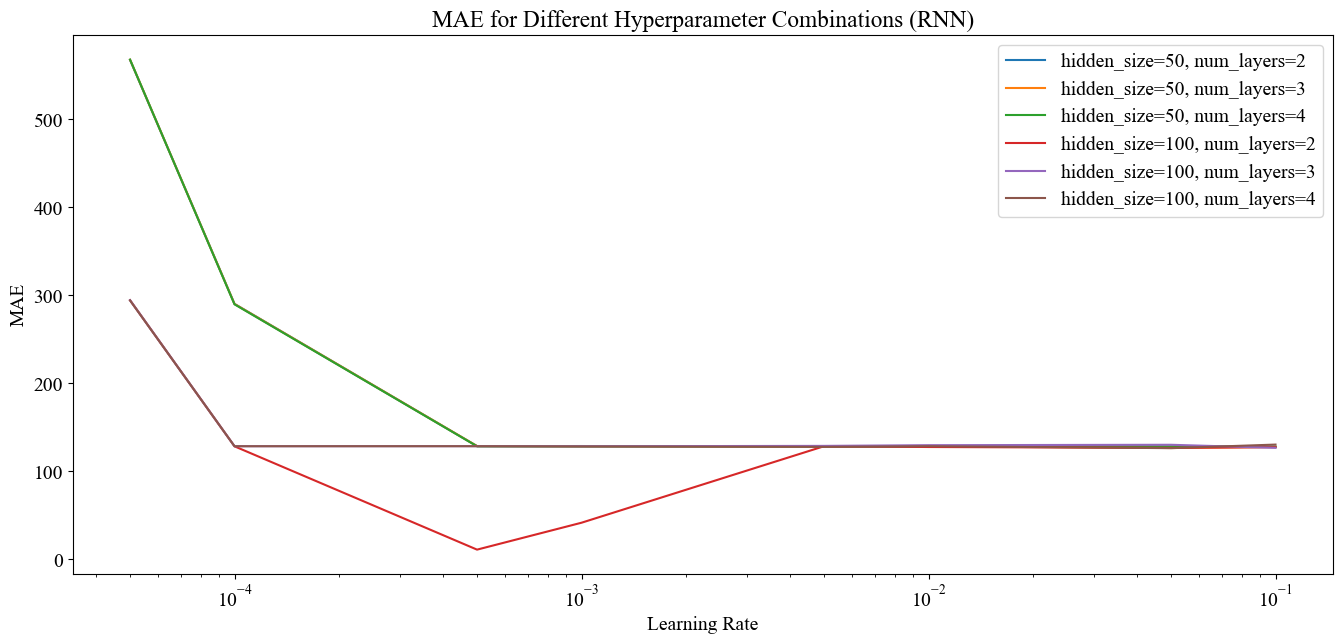

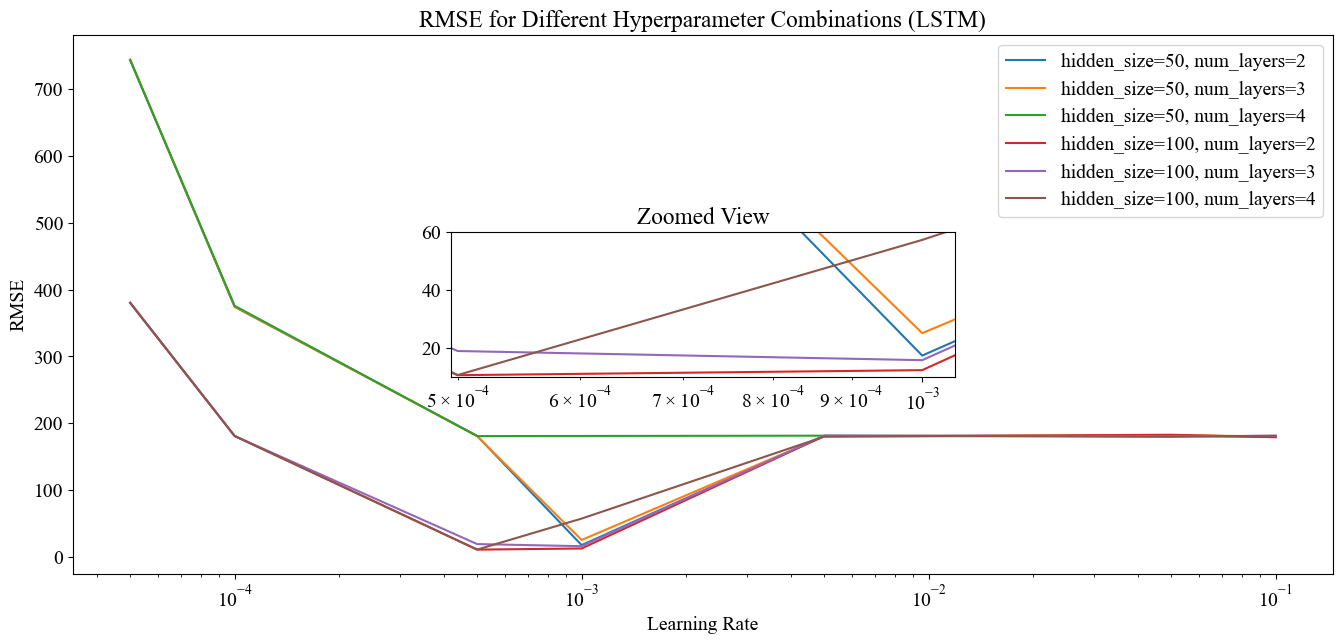

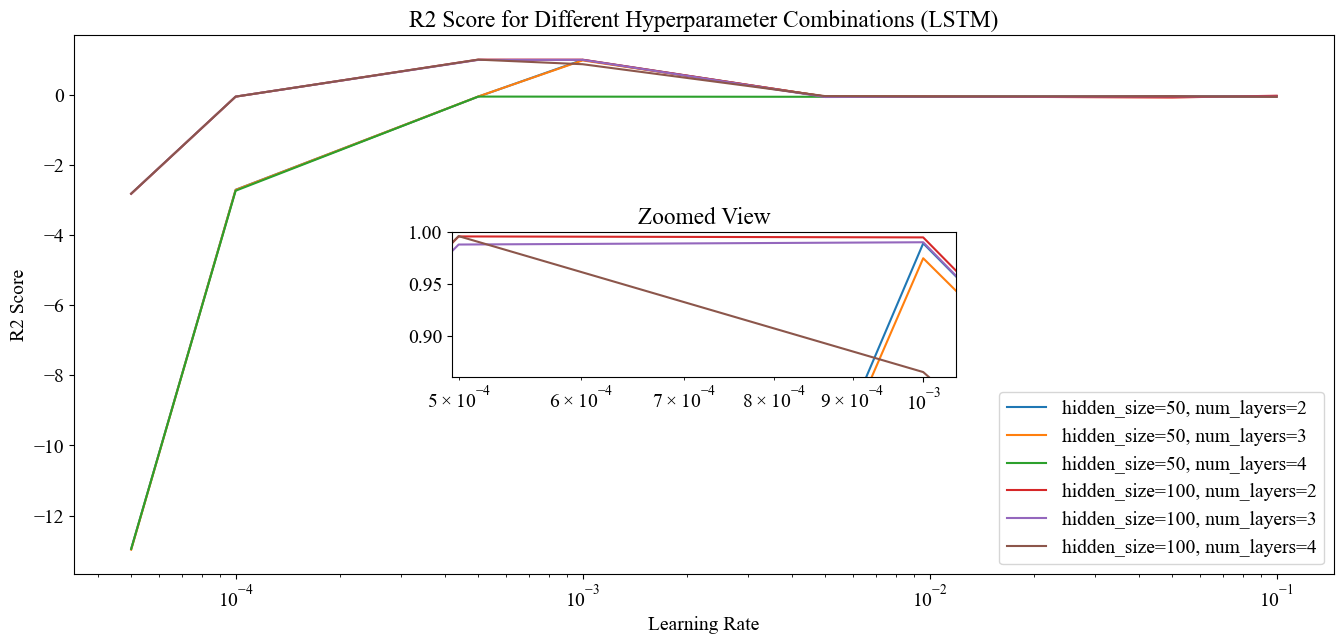

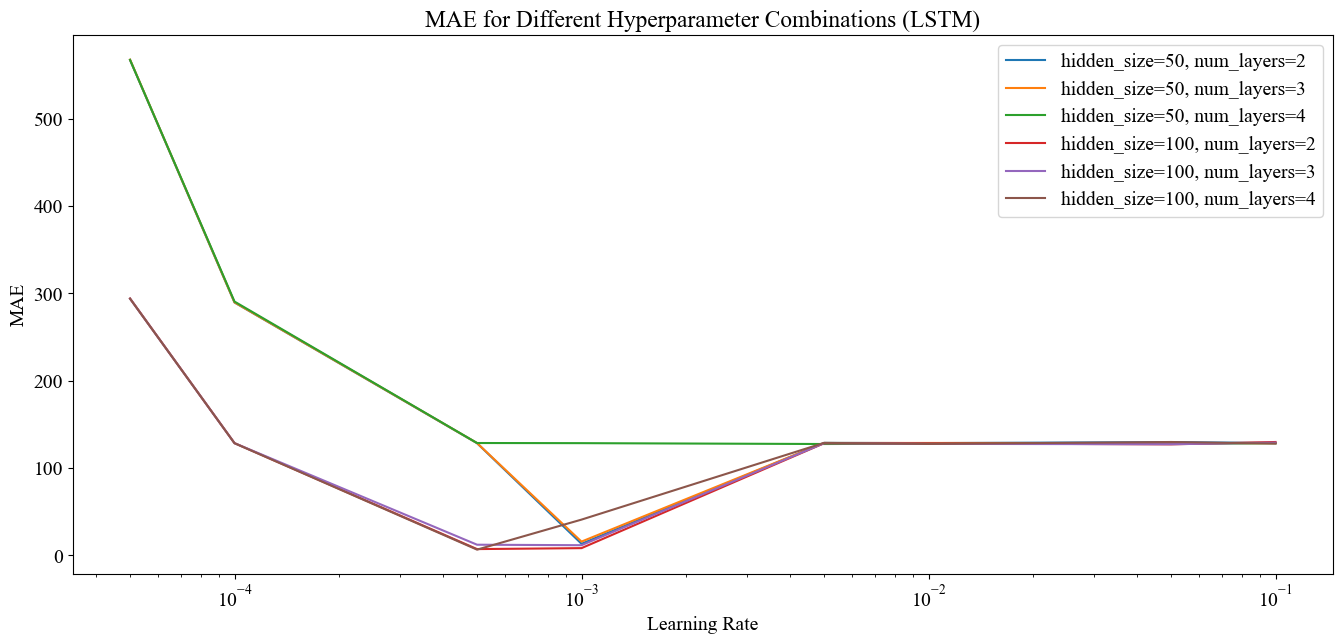

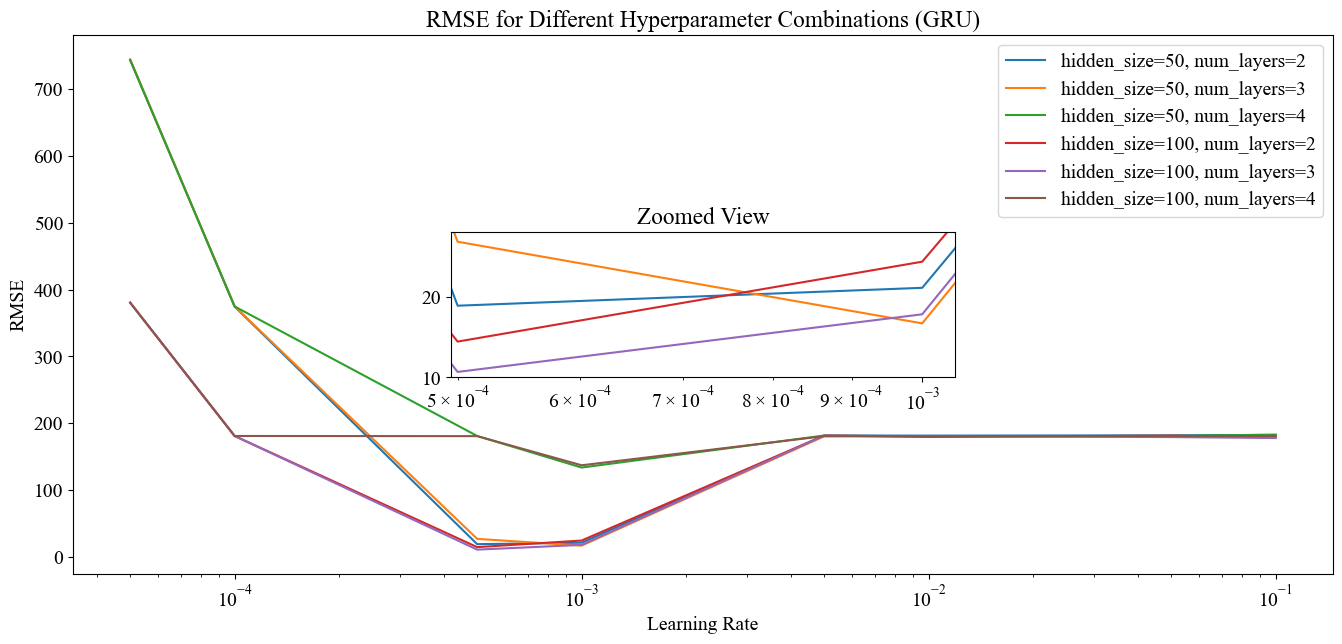

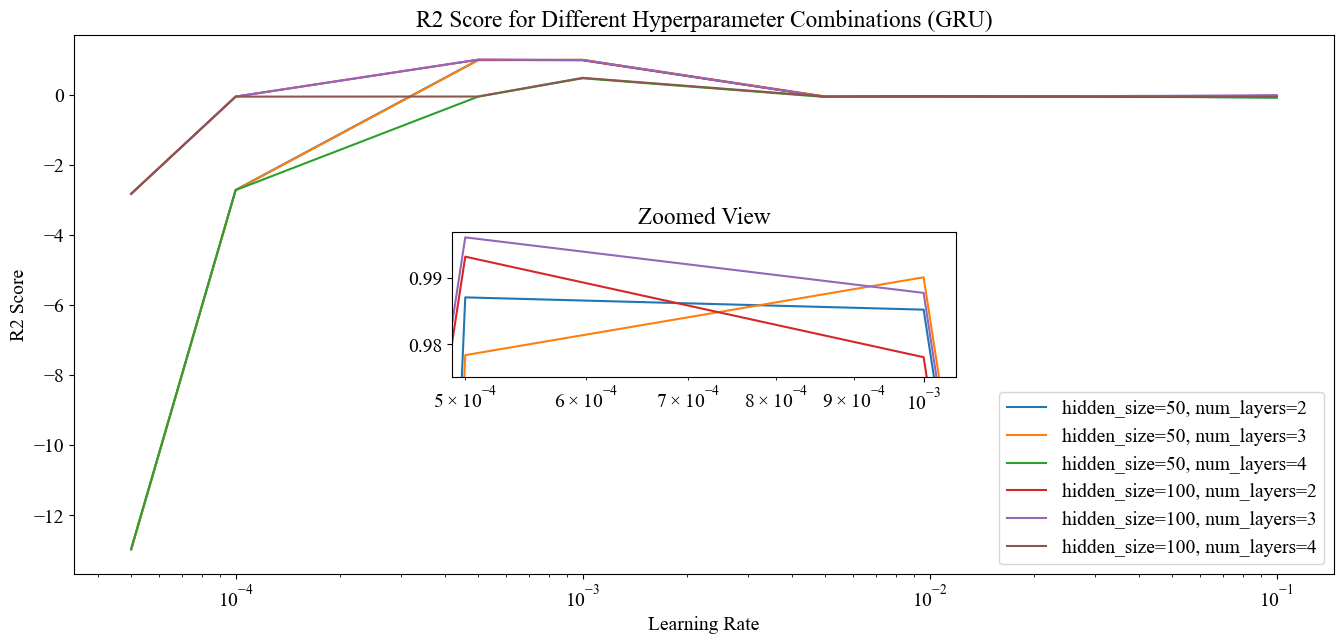

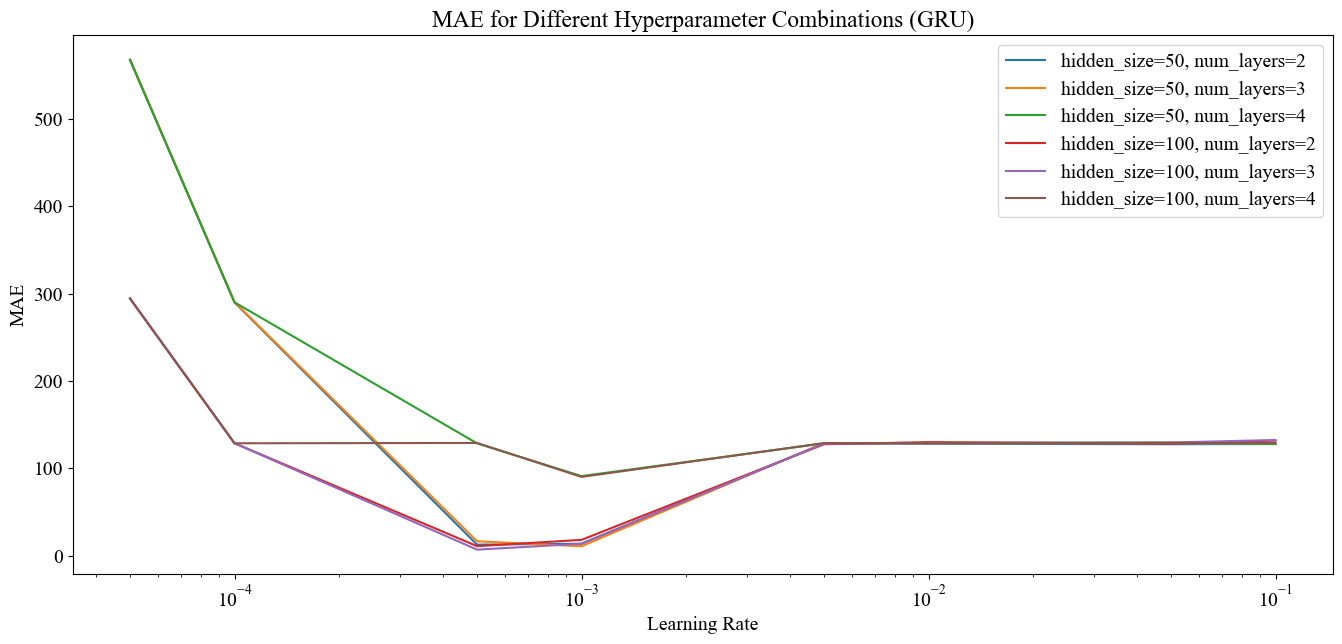

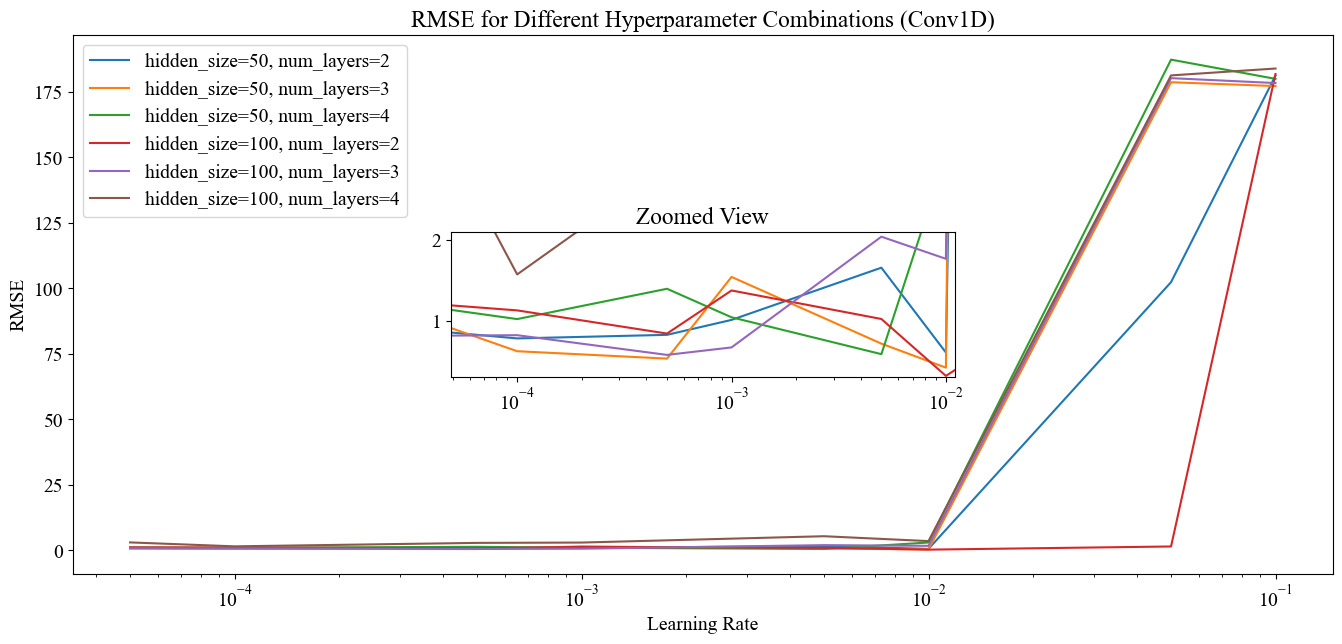

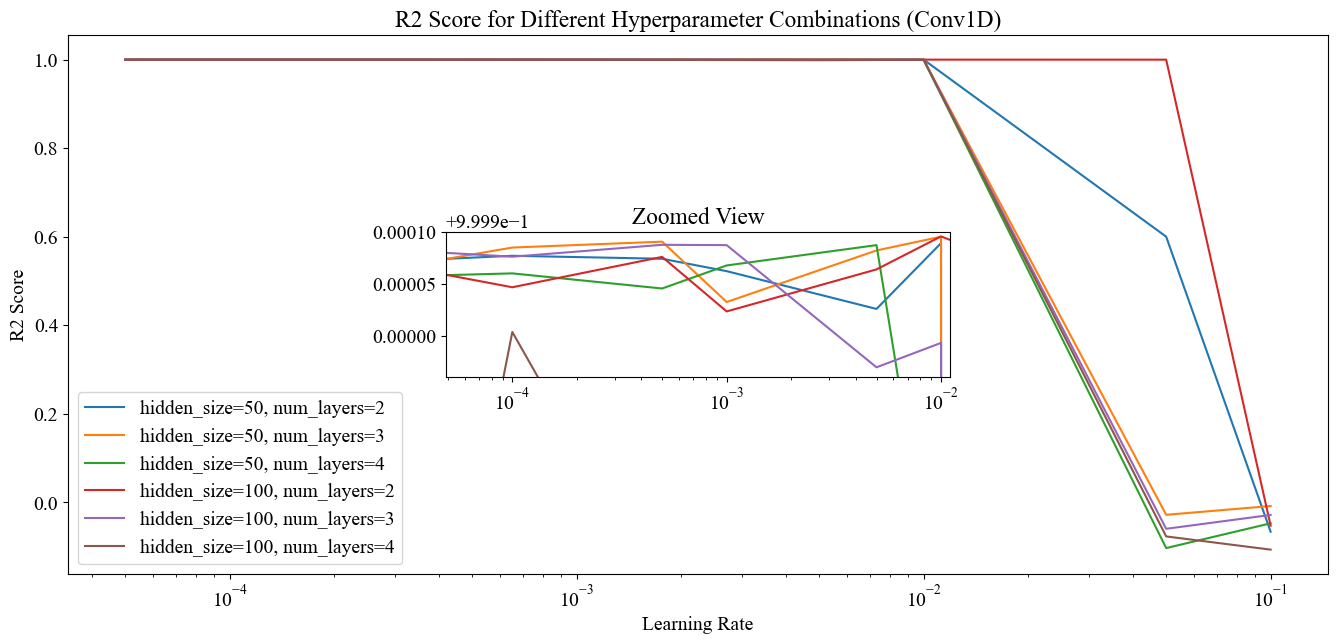

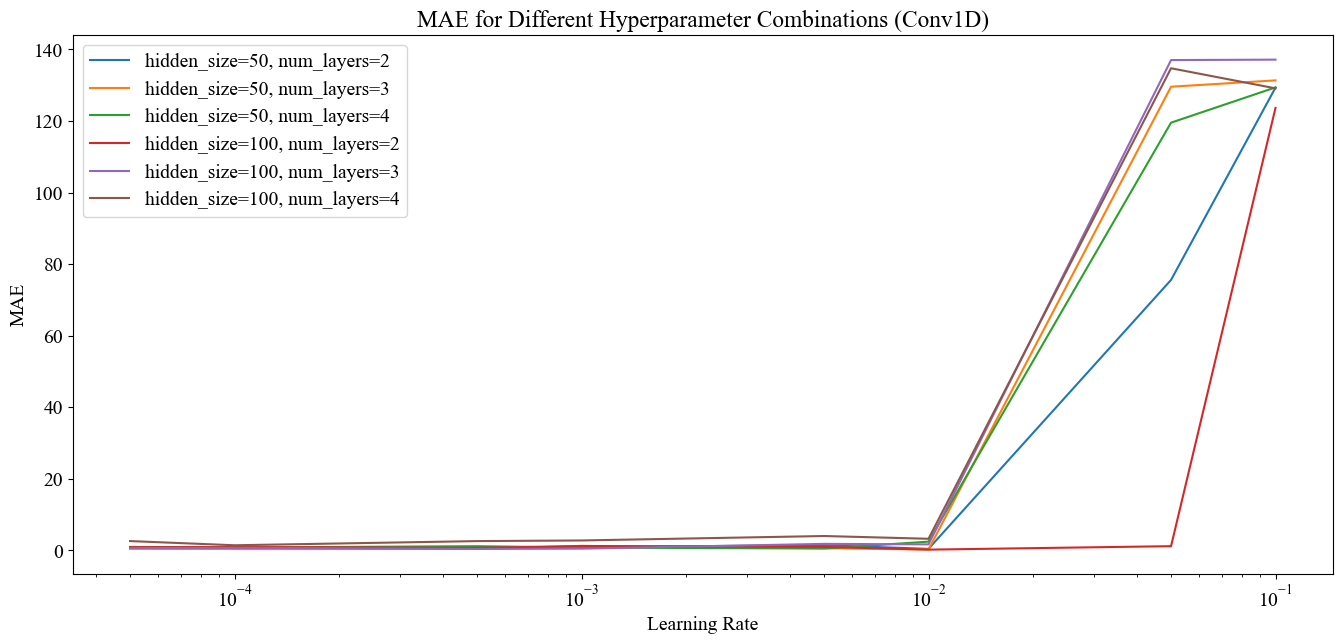

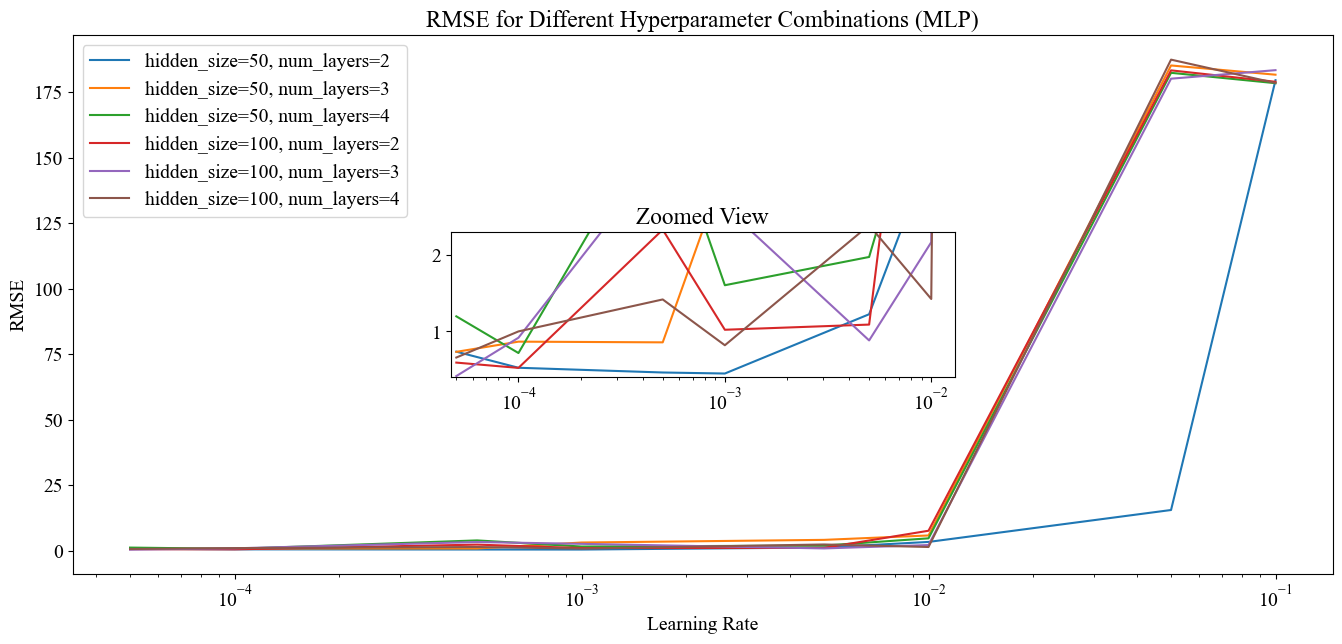

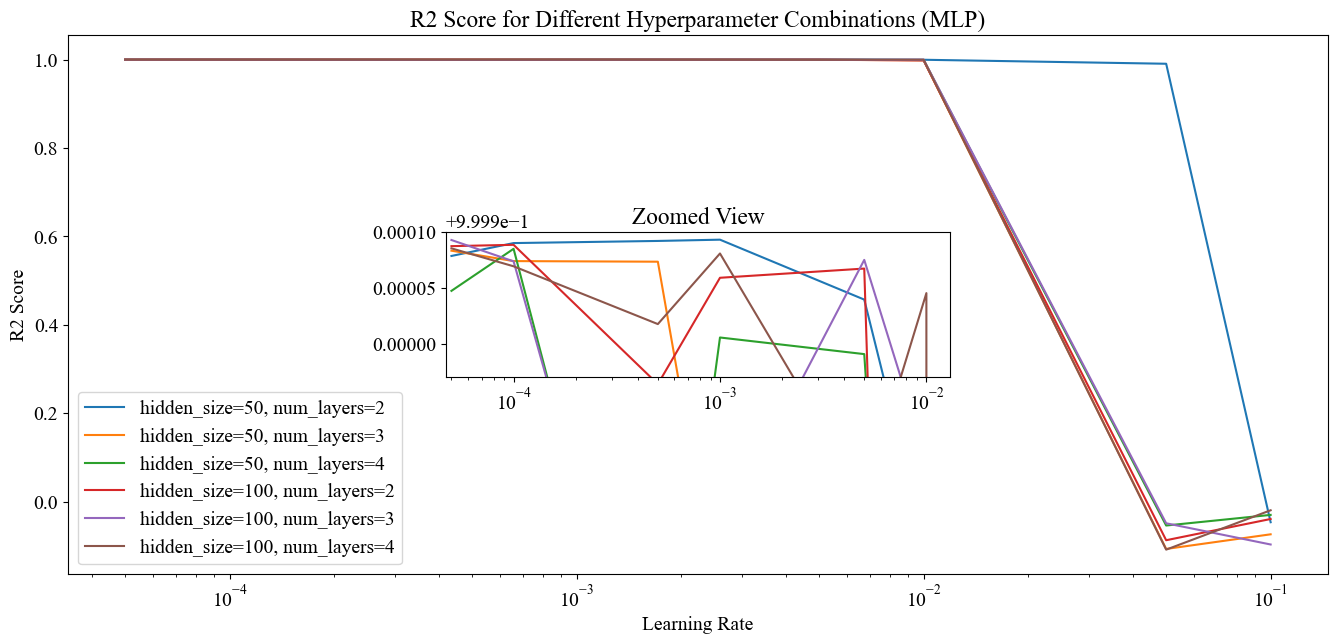

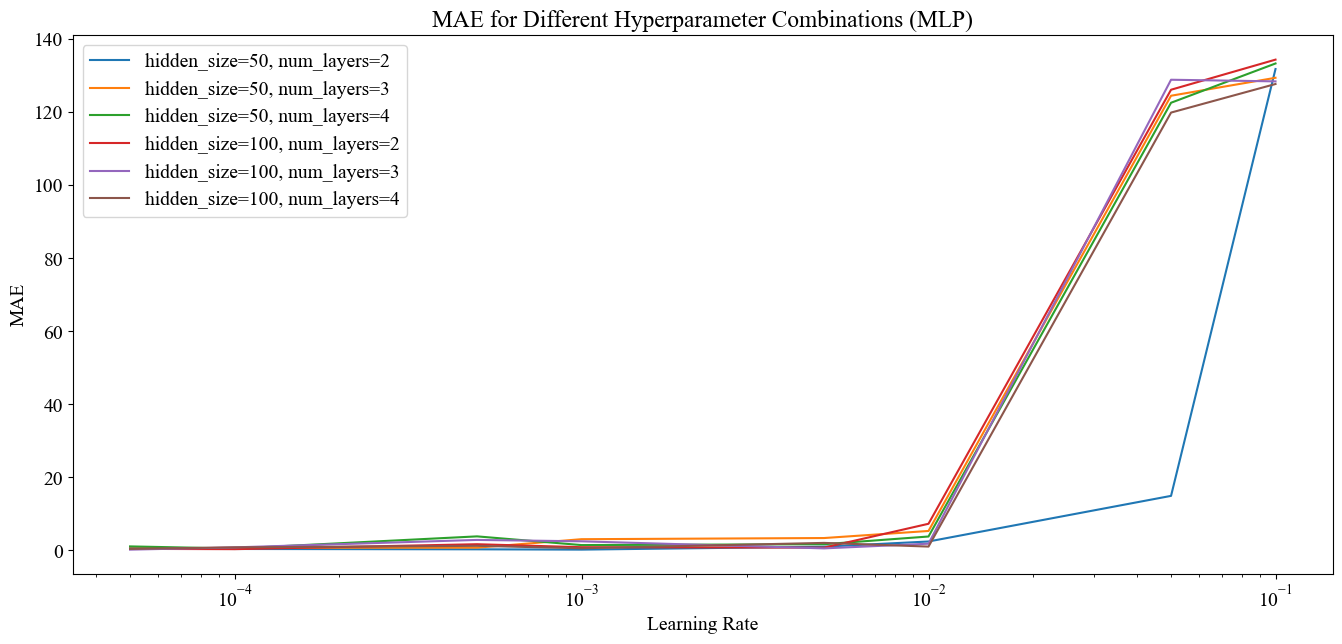

In [7]:
#@title Step 9: Visualize Results to evalate different hyperparameters

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#%%% # Define methods and their specific zoom parameters
methods = {
    'RNN': {},
    'LSTM': {'xlim_rmse': (4.95e-4, 1.05e-3), 'ylim_rmse': (10, 60), 'xlim_r2': (4.95e-4, 1.05e-3), 'ylim_r2': (0.86, 1)},
    'GRU': {'xlim_rmse': (4.95e-4, 1.05e-3), 'ylim_rmse': (10, 28), 'xlim_r2': (4.9e-4, 1.05e-3), 'ylim_r2': (0.975, 0.997)},
    'Conv1D': {'xlim_rmse': (4.9e-5, 1.1e-2), 'ylim_rmse': (0.3, 2.1), 'xlim_r2': (4.9e-5, 1.1e-2), 'ylim_r2': (0.99986, 1)},
    'MLP': {'xlim_rmse': (4.7e-5, 1.3e-2), 'ylim_rmse': (0.4, 2.3), 'xlim_r2': (4.7e-5, 1.3e-2), 'ylim_r2': (0.99987, 1)},
}

#%%% # Set global font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

#%%% # Loop through methods
for method, zoom_params in methods.items():
    save_path = f'Experiments/Tuning/hyperparam_tuning_{method}.csv'
    results_df = pd.read_csv(save_path)

    #%%% #------------------- RMSE -------------------#

    # Plot RMSE for different hyperparameters
    plt.figure(figsize=(14, 7))
    for key, grp in results_df.groupby(['hidden_size', 'num_layers']):
        plt.plot(grp['learning_rate'], grp['rmse'], label=f"hidden_size={key[0]}, num_layers={key[1]}")
    plt.xlabel('Learning Rate')
    plt.ylabel('RMSE')
    plt.xscale('log')
    plt.title(f'RMSE for Different Hyperparameter Combinations ({method})')
    plt.legend()

    # Add inset of zoomed region if not RNN
    if method != 'RNN':
        ax_inset = inset_axes(plt.gca(), width='40%', height='27%', loc='center', borderpad=2)
        for key, grp in results_df.groupby(['hidden_size', 'num_layers']):
            ax_inset.plot(grp['learning_rate'], grp['rmse'], label=f"hidden_size={key[0]}, num_layers={key[1]}")
        ax_inset.set_xlim(zoom_params['xlim_rmse'])  # Set the limits for x-axis
        ax_inset.set_ylim(zoom_params['ylim_rmse'])  # Set the limits for y-axis
        ax_inset.set_xscale('log')
        ax_inset.set_title('Zoomed View')
    
    plt.subplots_adjust(left=0.05, right=0.95)
    plt.savefig(f'Graphs/Tuning/rmse-{method.lower()}.svg', bbox_inches='tight')
    plt.show()

    #%%% #------------------- R2 Score -------------------#

    # Plot R2 Score for different hyperparameters
    plt.figure(figsize=(14, 7))
    for key, grp in results_df.groupby(['hidden_size', 'num_layers']):
        plt.plot(grp['learning_rate'], grp['r2'], label=f"hidden_size={key[0]}, num_layers={key[1]}")
    plt.xlabel('Learning Rate')
    plt.ylabel('R2 Score')
    plt.xscale('log')
    plt.title(f'R2 Score for Different Hyperparameter Combinations ({method})')
    plt.legend()

    # Add inset of zoomed region if not RNN
    if method != 'RNN':
        ax_inset = inset_axes(plt.gca(), width='40%', height='27%', loc='center', borderpad=2)
        for key, grp in results_df.groupby(['hidden_size', 'num_layers']):
            ax_inset.plot(grp['learning_rate'], grp['r2'], label=f"hidden_size={key[0]}, num_layers={key[1]}")
        ax_inset.set_xlim(zoom_params['xlim_r2'])  # Set the limits for x-axis
        ax_inset.set_ylim(zoom_params['ylim_r2'])  # Set the limits for y-axis
        ax_inset.set_xscale('log')
        ax_inset.set_title('Zoomed View')

    plt.subplots_adjust(left=0.05, right=0.95)
    plt.savefig(f'Graphs/Tuning/r2-{method.lower()}.svg', bbox_inches='tight')
    plt.show()

    #%%% #------------------- MAE -------------------#

    # # Plot MAE for different hyperparameters
    plt.figure(figsize=(14, 7))
    for key, grp in results_df.groupby(['hidden_size', 'num_layers']):
        plt.plot(grp['learning_rate'], grp['mae'], label=f"hidden_size={key[0]}, num_layers={key[1]}")
    plt.xlabel('Learning Rate')
    plt.ylabel('MAE')
    plt.xscale('log')
    plt.title(f'MAE for Different Hyperparameter Combinations ({method})')
    plt.legend()
    plt.subplots_adjust(left=0.05, right=0.95)
    plt.savefig(f'Graphs/Tuning/mae-{method.lower()}.svg', bbox_inches='tight')
    plt.show()


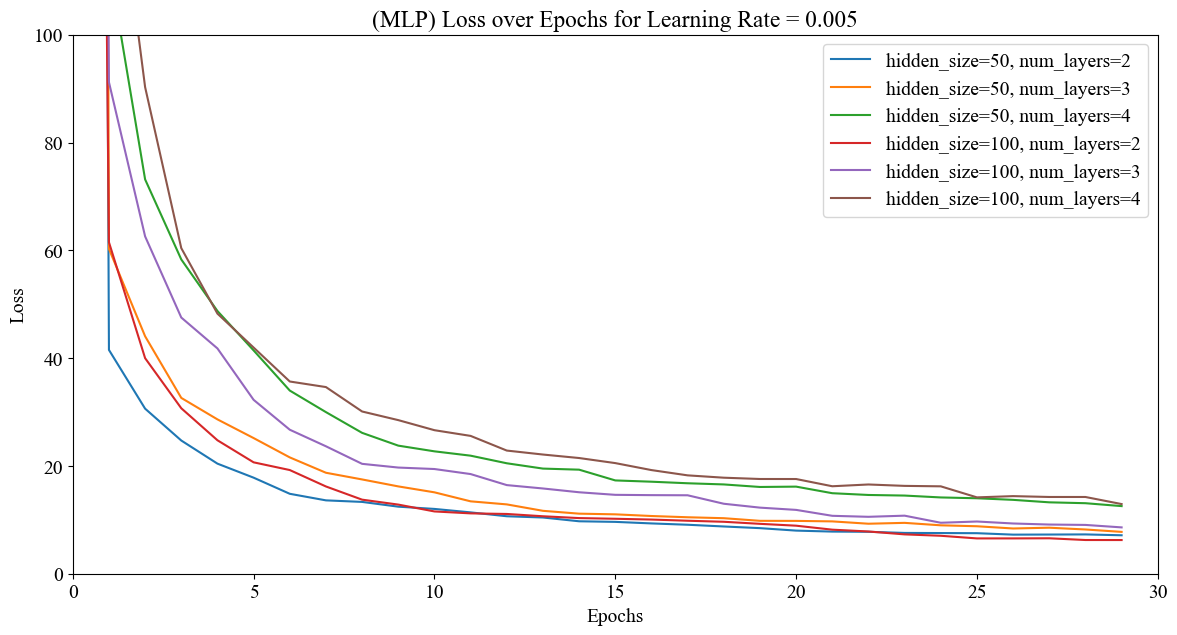

In [8]:
#@title Step 9b (optional): Visualize Results to evalate different hyperparameters for specific learning rates

# Define the specific learning rate you want to plot
method = 'MLP' # Choose from 'RNN', 'LSTM', 'GRU', 'Conv1D', 'MLP'
save_path = f'Experiments/Tuning/hyperparam_tuning_{method}.csv'
results_df = pd.read_csv(save_path)
specific_learning_rate = 0.005

# Filter the DataFrame to include only rows with the specific learning rate
filtered_df = results_df[results_df['learning_rate'] == specific_learning_rate]

# Plot loss over epochs for the filtered hyperparameter combinations
plt.figure(figsize=(14, 7))

for idx, result in filtered_df.iterrows():
    epoch_losses = eval(result['epoch_losses'])  # Convert string representation of list back to list
    plt.plot(epoch_losses, label=f"hidden_size={result['hidden_size']}, num_layers={result['num_layers']}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 100)
plt.xlim(0, 30)
plt.title(f'({method}) Loss over Epochs for Learning Rate = {specific_learning_rate}')
plt.legend()
plt.show()


In [53]:
#@title Step 10: Ranking hyperparameters and selecting the top experiments

import pandas as pd
import os
import numpy as np

# Methods to analyze
methods = ["RNN", "LSTM", "GRU", "Conv1D", "MLP"]

# Function to calculate the loss slope (rate of convergence)
def calculate_loss_slope(losses):
    if isinstance(losses, str):
        losses = eval(losses)  # Convert string representation of list back to list
    # Fit a linear model to the loss data (epochs vs loss)
    epochs = np.arange(1, len(losses) + 1)
    slope, _ = np.polyfit(epochs, losses, 1)
    return slope  # Slope of the loss curve

# Function to extract the final loss value and its corresponding epoch
def extract_final_loss(losses):
    if isinstance(losses, str):
        losses = eval(losses)  # Convert string representation of list back to list
    final_loss = losses[-1]  # The last recorded loss
    final_epoch = len(losses)  # The epoch corresponding to the final loss
    return final_loss, final_epoch

# Function to rank and select the top experiments
def select_top_experiments(df, epoch_time_weight=0.1, row_count=3):
    # Rank based on RMSE (lower is better)
    df['rank_rmse'] = df['rmse'].rank(ascending=True)
    # Rank based on MAE (lower is better)
    df['rank_mae'] = df['mae'].rank(ascending=True)
    # Rank based on R2 (higher is better)
    df['rank_r2'] = df['r2'].rank(ascending=False)
    # Normalize avg_epoch_time to a 0-1 scale
    df['norm_epoch_time'] = (df['avg_epoch_time'] - df['avg_epoch_time'].min()) / (df['avg_epoch_time'].max() - df['avg_epoch_time'].min())
    # Apply a weight to the normalized epoch time
    df['weighted_epoch_time'] = df['norm_epoch_time'] * epoch_time_weight
    # Calculate and rank based on loss slope (more negative slope is better)
    df['loss_slope'] = df['epoch_losses'].apply(calculate_loss_slope)
    df['rank_loss_slope'] = df['loss_slope'].rank(ascending=True) / 10
    
    # Extract final loss and corresponding epoch
    df[['final_loss', 'final_epoch']] = df['epoch_losses'].apply(lambda x: pd.Series(extract_final_loss(x)))
    
    # Rank based on final recorded loss (lower is better)
    df['rank_final_loss'] = df['final_loss'].rank(ascending=True)
    
    # Sum the ranks to get a combined score
    df['combined_rank'] = (df['rank_rmse'] + df['rank_mae'] + df['rank_r2'] +
                           df['weighted_epoch_time'] + df['rank_loss_slope'] + df['rank_final_loss'])
    
    # Sort by the combined rank and select the top experiments
    top_experiments = df.sort_values('combined_rank').head(row_count)
    
    # Convert ranking columns and final_epoch to integers where possible
    rank_columns = ['rank_rmse', 'rank_mae', 'rank_r2', 'rank_loss_slope', 'rank_final_loss', 'final_epoch']
    top_experiments[rank_columns] = top_experiments[rank_columns].map(lambda x: int(x) if isinstance(x, (int, float)) and x.is_integer() else x)
    
    # Round specific columns to 2 decimal places
    columns_to_round = ['rmse', 'mae', 'avg_epoch_time', 'epoch_losses', 'norm_epoch_time',
                        'weighted_epoch_time', 'loss_slope', 'final_loss', 'combined_rank']
    top_experiments[columns_to_round] = top_experiments[columns_to_round].round(2)
    
    return top_experiments

# Dictionary to store results
results = {}
row_count = 3 # the number of top experiments to select for each method

# Iterate over each method and process the corresponding file
for method in methods:
    filepath = f'Experiments/Tuning/hyperparam_tuning_{method}.csv'
    
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        top_experiments = select_top_experiments(df, row_count=row_count)
        results[method] = top_experiments
        # Save the top experiments to individual CSV files
        top_experiments.to_csv(f'Experiments/Tuning/top_{row_count}_experiment_(hyperparam_tuning)_{method}.csv', index=False)
    else:
        print(f"File {filepath} not found in the directory.")

# Extract the best experiment for each method and add the method name
best_experiments = []
for method, top_experiments in results.items():
    best_experiment = top_experiments.head(1).copy()
    best_experiment['method'] = method
    best_experiments.append(best_experiment)

# Combine all the best experiments into a single DataFrame
best_experiments_df = pd.concat(best_experiments)

# Reorder columns to place 'method' at the beginning
cols = best_experiments_df.columns.tolist()
cols = ['method'] + [col for col in cols if col != 'method']
best_experiments_df = best_experiments_df[cols]

# Save the combined DataFrame to a new CSV file
best_experiments_df.to_csv('Experiments/Tuning/best_hyperparam_sets_of_each_method.csv', index=False)

# Display the final DataFrame
display(best_experiments_df)

# import pandas as pd
# import os
# import numpy as np

# # Methods to analyze
# methods = ["RNN", "LSTM", "GRU", "Conv1D", "MLP"]

# # Function to calculate the loss slope (rate of convergence)
# def calculate_loss_slope(losses):
#     if isinstance(losses, str):
#         losses = eval(losses)  # Convert string representation of list back to list
#     # Fit a linear model to the loss data (epochs vs loss)
#     epochs = np.arange(1, len(losses) + 1)
#     slope, _ = np.polyfit(epochs, losses, 1)
#     return slope  # Slope of the loss curve

# # Function to extract the final loss value and its corresponding epoch
# def extract_final_loss(losses):
#     if isinstance(losses, str):
#         losses = eval(losses)  # Convert string representation of list back to list
#     final_loss = losses[-1]  # The last recorded loss
#     final_epoch = len(losses)  # The epoch corresponding to the final loss
#     return final_loss, final_epoch

# # Function to rank and select the top experiments
# def select_top_experiments(df, epoch_time_weight=0.1, row_count=3):
#     # Rank based on RMSE (lower is better)
#     df['rank_rmse'] = df['rmse'].rank(ascending=True)
#     # Rank based on MAE (lower is better)
#     df['rank_mae'] = df['mae'].rank(ascending=True)
#     # Rank based on R2 (higher is better)
#     df['rank_r2'] = df['r2'].rank(ascending=False)
#     # Normalize avg_epoch_time to a 0-1 scale
#     df['norm_epoch_time'] = (df['avg_epoch_time'] - df['avg_epoch_time'].min()) / (df['avg_epoch_time'].max() - df['avg_epoch_time'].min())
#     # Apply a weight to the normalized epoch time
#     df['weighted_epoch_time'] = df['norm_epoch_time'] * epoch_time_weight
#     # Calculate and rank based on loss slope (more negative slope is better)
#     df['loss_slope'] = df['epoch_losses'].apply(calculate_loss_slope)
#     df['rank_loss_slope'] = df['loss_slope'].rank(ascending=True) / 10
    
#     # Extract final loss and corresponding epoch
#     df[['final_loss', 'final_epoch']] = df['epoch_losses'].apply(lambda x: pd.Series(extract_final_loss(x)))
    
#     # Rank based on final recorded loss (lower is better)
#     df['rank_final_loss'] = df['final_loss'].rank(ascending=True)
    
#     # Sum the ranks to get a combined score
#     df['combined_rank'] = (df['rank_rmse'] + df['rank_mae'] + df['rank_r2'] +
#                            df['weighted_epoch_time'] + df['rank_loss_slope'] + df['rank_final_loss'])
    
#     # Sort by the combined rank and select the top experiments
#     top_experiments = df.sort_values('combined_rank').head(3) # change 3 to get more rows for more analysis
    
#     # Convert ranking columns and final_epoch to integers where possible
#     rank_columns = ['rank_rmse', 'rank_mae', 'rank_r2', 'rank_loss_slope', 'rank_final_loss', 'final_epoch']
#     top_experiments[rank_columns] = top_experiments[rank_columns].map(lambda x: int(x) if isinstance(x, (int, float)) and x.is_integer() else x)
    
#     # Round specific columns to 2 decimal places
#     columns_to_round = ['rmse', 'mae', 'avg_epoch_time', 'epoch_losses', 'norm_epoch_time',
#                         'weighted_epoch_time', 'loss_slope', 'final_loss', 'combined_rank']
#     top_experiments[columns_to_round] = top_experiments[columns_to_round].round(2)
    
#     return top_experiments

# # Dictionary to store results
# results = {}
# row_count = 3 # the number of top experiments to select for each method

# # Iterate over each method and process the corresponding file
# for method in methods:
#     filepath = f'Experiments/Tuning/hyperparam_tuning_{method}.csv'
    
#     if os.path.exists(filepath):
#         df = pd.read_csv(filepath)
#         top_experiments = select_top_experiments(df, row_count=3)
#         results[method] = top_experiments
#     else:
#         print(f"File {filepath} not found in the directory.")

# # Display the results for each method
# for method, top_experiments in results.items():
#     print(f"Top experiments for {method}:")
#     display(top_experiments)
#     print("\n")

# # Saving the best results to new CSV files
# for method, top_experiments in results.items():
#     top_experiments.to_csv(f'Experiments/Tuning/top_{row_count}_experiment_(hyperparam_tuning)_{method}.csv', index=False)


Top experiments for RNN:


,hidden_size,num_layers,learning_rate,num_epochs,rmse,mae,r2,avg_epoch_time,epoch_losses,rank_rmse,rank_mae,rank_r2,norm_epoch_time,weighted_epoch_time,loss_slope,rank_loss_slope,final_loss,final_epoch,rank_final_loss,combined_rank
29,100,2,0.0005,30,16.26,11.05,0.988963,18.12,"[1142544.0048273744, 624526.601443095, 302998....",1,1,1,0.01,0.0,-13770.32,3.5,115.46,30,1,7.5
28,100,2,0.0010,30,59.52,41.63,0.871212,18.25,"[891363.4259560931, 227571.66610784407, 40707....",2,2,2,0.05,0.0,-7377.25,3.9,3824.85,30,2,11.9
25,100,2,0.0500,30,180.51,126.69,-0.046982,18.20,"[59903.988529122034, 35923.78601913785, 35920....",6,5,3,0.03,0.0,-4793.77,4.1,35930.73,5,35,53.1




Top experiments for LSTM:


,hidden_size,num_layers,learning_rate,num_epochs,rmse,mae,r2,avg_epoch_time,epoch_losses,rank_rmse,rank_mae,rank_r2,norm_epoch_time,weighted_epoch_time,loss_slope,rank_loss_slope,final_loss,final_epoch,rank_final_loss,combined_rank
45,100,4,0.0005,30,10.80,6.68,0.995892,23.69,"[1138733.7401832014, 622094.5364824986, 301534...",2,1,1,0.98,0.10,-13831.96,3.1,53.01,30,1,8.20
29,100,2,0.0005,30,10.76,7.30,0.995611,20.53,"[1137920.7277480213, 621599.9580547216, 301137...",1,2,2,0.20,0.02,-13693.50,3.5,67.74,30,2,10.52
28,100,2,0.0010,30,12.49,8.39,0.994678,20.39,"[886613.1514098322, 225806.8042141444, 40056.7...",3,3,3,0.16,0.02,-7430.99,4.5,213.96,30,5,18.52




Top experiments for GRU:


,hidden_size,num_layers,learning_rate,num_epochs,rmse,mae,r2,avg_epoch_time,epoch_losses,rank_rmse,rank_mae,rank_r2,norm_epoch_time,weighted_epoch_time,loss_slope,rank_loss_slope,final_loss,final_epoch,rank_final_loss,combined_rank
37,100,3,0.0005,30,10.68,6.84,0.996168,22.88,"[1140825.723517672, 623556.2029672147, 302359....",1,1,1,0.74,0.07,-13803.36,3.0,104.95,30,2,8.07
29,100,2,0.0005,30,14.43,10.81,0.993252,21.95,"[1140698.1336909798, 623318.1916578534, 302346...",2,3,2,0.56,0.06,-13685.10,3.2,96.07,30,1,11.26
12,50,3,0.0010,30,16.68,10.71,0.990130,21.16,"[1140335.3430591566, 619464.186335801, 297491....",3,2,3,0.41,0.04,-13938.91,2.9,410.59,30,6,16.94




Top experiments for Conv1D:


,hidden_size,num_layers,learning_rate,num_epochs,rmse,mae,r2,avg_epoch_time,epoch_losses,rank_rmse,rank_mae,rank_r2,norm_epoch_time,weighted_epoch_time,loss_slope,rank_loss_slope,final_loss,final_epoch,rank_final_loss,combined_rank
14,50,3,0.0001,30,0.62,0.37,0.999985,18.44,"[15143.85223824918, 38.63159645345534, 14.4529...",7,3,8,0.46,0.05,-98.06,1.4,0.83,30,7,26.45
13,50,3,0.0005,30,0.53,0.40,0.999991,18.45,"[3715.559050297047, 16.55730773009132, 10.2897...",3,4,3,0.47,0.05,-24.21,2.3,1.90,30,16,28.35
6,50,2,0.0001,30,0.78,0.50,0.999977,16.73,"[20230.053307635295, 74.73209363703644, 35.547...",10,7,11,0.02,0.00,-131.27,1.2,0.67,30,3,32.20




Top experiments for MLP:


,hidden_size,num_layers,learning_rate,num_epochs,rmse,mae,r2,avg_epoch_time,epoch_losses,rank_rmse,rank_mae,rank_r2,norm_epoch_time,weighted_epoch_time,loss_slope,rank_loss_slope,final_loss,final_epoch,rank_final_loss,combined_rank
39,100,3,0.00005,30,0.42,0.23,0.999993,15.78,"[32811.94768182413, 55.267583626066234, 16.063...",1,1,2,0.37,0.04,-212.14,1.3,0.36,30,2,7.34
6,50,2,0.00010,30,0.53,0.41,0.999990,14.30,"[33932.106995955175, 50.313148681318395, 20.61...",5,5,4,0.01,0.00,-219.43,1.2,0.35,30,1,16.20
30,100,2,0.00010,30,0.52,0.36,0.999988,14.41,"[16509.936249956685, 27.598385056049672, 7.226...",4,4,5,0.03,0.00,-106.75,2.0,0.38,30,3,18.00


In [65]:
import pandas as pd
import pyperclip

# List of methods to include
methods = ["RNN", "LSTM", "GRU", "Conv1D", "MLP"]

# Columns to select for the LaTeX table
columns_to_include = ['Method', 'hidden_size', 'num_layers', 'learning_rate', 'rmse', 
                      'mae', 'r2', 'avg_epoch_time', 'final_loss', 'final_epoch', 'combined_rank']

# Dictionary to store data from CSV files
all_experiments = []

# Read the top experiments from each CSV file and add the method name
for method in methods:
    filepath = f'top_experiments_{method}.csv'
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        df.insert(0, 'Method', method)  # Insert method name as the first column
        df_filtered = df[columns_to_include]  # Filter to include only the specified columns
        all_experiments.append(df_filtered)

# Concatenate all data into a single DataFrame
big_table = pd.concat(all_experiments, ignore_index=True)

# Format the R2 column to 4 decimal places
big_table['r2'] = big_table['r2'].apply(lambda x: f"{x:.4f}")

# Create LaTeX table with row merging and row highlighting for the best experiment of each method
latex_table = "\\begin{table}[htbp]\n\\centering\n\\resizebox{\\textwidth}{!}{%\n"
latex_table += "\\begin{tabular}{C{0.8cm}C{0.7cm}C{0.8cm}C{1cm}C{1cm}C{1cm}C{1cm}C{1.3cm}C{1cm}C{1cm}C{1cm}}\n"
latex_table += "\\hline\nMethod & Hidden Size & Layers & $\\alpha$ & RMSE & MAE & R2 & Avg Epoch Time & Final Loss & Final Epoch & Combined Rank \\\\\n"
latex_table += "\\hline\n"

# Loop through the DataFrame and add rows to the LaTeX table
for i, (index, row) in enumerate(big_table.iterrows()):
    if i % 3 == 0:  # Merge the first column for the first row of each method and highlight
        latex_table += f"\\multirow{{3}}{{*}}{{{row['Method']}}} & \\rowcolor{{green!30}} "  # Merge first column and highlight
        latex_table += " & ".join(map(str, row.values[1:])) + " \\\\\n"
    else:
        latex_table += " & " + " & ".join(map(str, row.values[1:])) + " \\\\\n"

latex_table += "\\hline\n\\end{tabular}}\n\\caption{Top Experiments for Each Method}\n\\end{table}"

# Print the LaTeX code
print(latex_table)

# Copy the LaTeX code to the clipboard
pyperclip.copy(latex_table)
print("LaTeX code has been copied to the clipboard.")


\begin{table}[htbp]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{C{0.8cm}C{0.7cm}C{0.8cm}C{1cm}C{1cm}C{1cm}C{1cm}C{1.3cm}C{1cm}C{1cm}C{1cm}}
\hline
Method & Hidden Size & Layers & $\alpha$ & RMSE & MAE & R2 & Avg Epoch Time & Final Loss & Final Epoch & Combined Rank \\
\hline
\multirow{3}{*}{RNN} & \rowcolor{green!30} 100 & 2 & 0.0005 & 16.26 & 11.05 & 0.9890 & 18.12 & 115.46 & 30 & 7.5 \\
 & 100 & 2 & 0.001 & 59.52 & 41.63 & 0.8712 & 18.25 & 3824.85 & 30 & 11.9 \\
 & 100 & 2 & 0.05 & 180.51 & 126.69 & -0.0470 & 18.2 & 35930.73 & 5 & 53.1 \\
\multirow{3}{*}{LSTM} & \rowcolor{green!30} 100 & 4 & 0.0005 & 10.8 & 6.68 & 0.9959 & 23.69 & 53.01 & 30 & 8.2 \\
 & 100 & 2 & 0.0005 & 10.76 & 7.3 & 0.9956 & 20.53 & 67.74 & 30 & 10.52 \\
 & 100 & 2 & 0.001 & 12.49 & 8.39 & 0.9947 & 20.39 & 213.96 & 30 & 18.52 \\
\multirow{3}{*}{GRU} & \rowcolor{green!30} 100 & 3 & 0.0005 & 10.68 & 6.84 & 0.9962 & 22.88 & 104.95 & 30 & 8.07 \\
 & 100 & 2 & 0.0005 & 14.43 & 10.81 & 0.9933 & 21.95 & 96.07 